# Grab spectograms from the H5 files, resize them to the first 100 ms but leave them as 2D arrays. 
## stick them in a np.array (X)
## Then we're going to analyze them- 
## for now that just invovles PCA them, UMAP that, and plot the results. May as well cluster them too.
## the plan is to use a neural network though

## Assume we have a folder with calls as .wav files (from soundsep)
## Produce a bunch of spectrograms for clustering. Probably do PCA, we'll see

In [1]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

In [2]:
desired_length = 100 # in ms # change if you want to play with this- all files will be truncated to this length or padded with zeros

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
# find the shortest file and the longest file but this isn't really necessary
# print(f'number of files: {len(wav_list)}')
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
# longest_file = wav_list[np.argmax(wav_lengths)]
# print(f' shortest file: {shortest_file} \n longest file: {longest_file}')
# # read the shortest file
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))
# print(f'fs: {fs} \n data shape: {data.shape}, length: {data.shape[0]/fs} seconds')
# # read the longest file
# fs, data = read(os.path.join(base_folder,'wavs',longest_file))
# print(f'fs: {fs} \n data shape: {data.shape}, length: {data.shape[0]/fs} seconds')
print(f'fs = {fs} Hz, desired length = {desired_length} ms')
# desired_length = int(desired_length * fs) # in data points
# print(f'desired length: {desired_length} data points')


fs = 48000 Hz, desired length = 100 ms


In [3]:
# Wait I can do this in the H5 files
os.chdir(os.path.join(base_folder,'h5filesAmp'))
h5_files = [f for f in os.listdir() if f.endswith('.h5')]

tableStore = os.path.join(base_folder,'spec_results','vocSelTableSprectro.h5')
pcInfo = os.path.join(base_folder,'spec_results','vocSpectroPC.pkl')


## check the size of our spectrograms, verify they all have the same frequency bins (just errors if they don't)
## then just take the firs 100 ms (desired_length) of time bins and put them all in a np.array for sorting
## TODO potentially save the file list and the array (X) in an object or something

In [5]:
# Verify the size our spectrograms will be
# Set true if you want to normalize all spectrograms.
normFlg = True
#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 50
# Read the files to allocate space for np array
count = 0
shapeSpectro = []
birdName = []
callType = []
lengths = list()
for fname in h5_files:
    myBioSound = BioSound()
    myBioSound.readh5(fname)
    lengths.append(len(myBioSound.sound))
    shapeSpectro.append(myBioSound.spectro.shape)
    # print(f'spectrogram shapes: {shapeSpectro[-1]}')
    birdName.append(np.array2string(myBioSound.emitter)[2:-1])
    callType.append(np.array2string(myBioSound.type)[2:-1])
    count += 1

shapeSpectro.sort()

num_freq_bins = [shape[0] for shape in shapeSpectro]
if len(np.unique(num_freq_bins)) > 1:
    print(f'WARNING: calls are not all the same length')  
    print(f'frequncy bins: {np.unique(num_freq_bins)}')
else:
    print(f'All spectrograms have {num_freq_bins[0]} frequency bins')
    num_freq_bins = num_freq_bins[0]
print(f'time bins are {myBioSound.to[1]-myBioSound.to[0]} ms')
num_time_bins = int((desired_length/1000)/(myBioSound.to[1]-myBioSound.to[0]))
print(f'We will be taking {num_time_bins} time bins')
print(f'Allocating space for {count} spectrograms, shape: {count} x {num_freq_bins} x {num_time_bins}')
X = np.zeros((count, num_freq_bins, num_time_bins))
time_bins = myBioSound.to[0:num_time_bins]
freq_bins = myBioSound.fo

All spectrograms have 101 frequency bins
time bins are 0.001 ms
We will be taking 100 time bins
Allocating space for 4344 spectrograms, shape: 4344 x 101 x 100


In [6]:
#plot a histogram of lengths of spectrograms
# you only need to do this if you're interested in what a good spectrogram lenght for your particular data is: I am goign to go with 100 ms for now

# plt.hist([s[1] for s in shapeSpectro], bins=100)
# plt.xlabel('Length of spectrogram')
# plt.ylabel('Number of spectrograms')
# plt.title('Histogram of lengths of spectrograms')
# # print the mode
# print(f'Mode of spectrogram lengths: {Counter([s[1] for s in shapeSpectro]).most_common(1)}')

# # plot a histogram of lengths of calls
# plt.figure()
# plt.hist(lengths, bins=100)
# plt.xlabel('Length of call')
# plt.ylabel('Number of calls')
# plt.title('Histogram of lengths of calls')
# # print the mode
# print(f'Mode of call lengths: {Counter(lengths).most_common(1)}')
  


In [8]:
# check all the spectrogram shapes and adjust them to the desired length
for i, file in enumerate(h5_files):
    myBioSound = BioSound()
    myBioSound.readh5(file)
    if myBioSound.spectro.shape[1] < num_time_bins:
        myBioSound.spectro = np.pad(myBioSound.spectro, ((0,0),(0,num_time_bins-myBioSound.spectro.shape[1])), 'constant')
        X[i,:,:] = myBioSound.spectro
    elif myBioSound.spectro.shape[1] > num_time_bins: # if it's longer than desired, truncate it taking the first num_time_bins, TODO take the center of the syllable instead or make it optional
        X[i,:,:] = myBioSound.spectro[:,:num_time_bins]

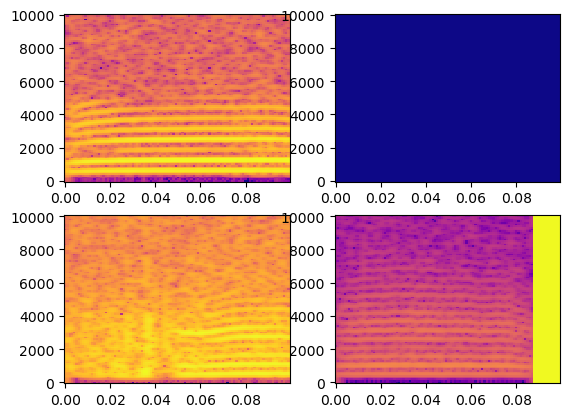

In [15]:
# you can plot a couple of the spectograms to make sure they look ok by changing the index
index = 10
plt.figure()
plt.subplot(2,2,1)
plt.pcolormesh(time_bins, freq_bins, X[index,:,:], cmap='plasma', shading='auto')
plt.subplot(2,2,2)
plt.pcolormesh(time_bins, freq_bins, X[index+1,:,:], cmap='plasma', shading='auto')
plt.subplot(2,2,3)
plt.pcolormesh(time_bins, freq_bins, X[index+2,:,:], cmap='plasma', shading='auto')
plt.subplot(2,2,4)
plt.pcolormesh(time_bins, freq_bins, X[index+3,:,:], cmap='plasma', shading='auto')


# TODO figure out why the spectrogram associated with index 

In [38]:
# This is the code from the original script that I need to modify to work with the new data structure


# Loop again to extract spectrogram, store the in X and calculate PC 
# # make it a function and run in parallel


# Looping through all the files
count = 0
for fname in h5_files[0:10]:
    # Allocate object and read data
    myBioSound = BioSound()
    myBioSound.readh5(fname)
    
    # Massage spectrogram as in matlab code (DFA_Calls_Julie)
    if normFlg:  # Normalize by peak
        myBioSound.spectro -= myBioSound.spectro.max()

    # Set a 100 dB range threshold
    maxAmp = myBioSound.spectro.max()
    minAmp = maxAmp - 100
    myBioSound.spectro[myBioSound.spectro < minAmp] = minAmp

# TODO make the line below not just cut data when one spectrogram is larger than the others
    # X[count,:] = np.ravel(myBioSound.spectro[0:shapeDesired[0], 0:shapeDesired[1]]) # Reshape to 1D array 
    print(X[count].shape)
    count +=1
            
print('Read %d files and spectrograms' % count)
print('Performing PCA')

# pca = PCA(n_components=nPCs)
# Xr = pca.fit_transform(X)  
 
# # Write PCA information in pkl                         
# pcInfoFile = open(pcInfo, 'wb')

# pickle.dump(pca.components_, pcInfoFile)

# print('PCA Done: Wrote PC\'s to pickle file %s' % pcInfoFile)
# print ('Variance explained is %.2f%%' % (sum(pca.explained_variance_ratio_)*100.0))

(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)
(101, 100)

In [16]:
# Make the pandas data frame with all the spectrograms
vocSelData = []
for ic in range(count):         
    vocSelData.append({"Bird": birdName[ic], 
                       "Calltype": callType[ic], 
                       "Spectro": Xr[ic]}) 
     

# Make a panda data frame with all the data  
print('Reprocessed %d files to make Panda Data Frame'%count)                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')
print('Done: Wrote pandas data frame to h5 file %s' % tableStore)

Reprocessed 4344 files to make Panda Data Frame
Done: Wrote pandas data frame to h5 file /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/spec_results/vocSelTableSprectro.h5


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_80884/2593386722.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Bird', 'Calltype', 'Spectro'], dtype='object')]

  vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')


In [73]:
# what's the size of our spectrograms
print(f'spectrogram shapes: {vocSelData[0]["Spectro"].shape}')

spectrogram shapes: (50,)


In [56]:
vocSelTable

,Bird,Calltype,Spectro,CalltypeInt
0,WhiWhi6607F,"[""0""]","[63.42924852709484, 56.11395765211436, -91.783...",0
1,BluGre1214F,"[""6""]","[-35.66054279508094, -35.138289317089246, -66....",6
2,BluGre1214F,"[""5""]","[-160.1451523706803, 14.28091251470568, 69.763...",5
3,WhiWhi6607F,"[""6""]","[-129.66537858448933, 49.69354168400685, -46.6...",6
4,BroGre1354M,"[""5""]","[-22.655207126976396, -50.65861418327188, 64.7...",5
...,...,...,...,...
4339,WhiWhi1541M,"[""5""]","[165.7301080510281, 98.12409144917115, 121.599...",5
4340,WhiWhi6607F,"[""6""]","[-147.47434274242164, 4.0269460199855285, 35.2...",6
4341,WhiWhi6607F,"[""6""]","[-189.7559765072306, 49.89283010212444, 2.4461...",6
4342,BluGre1214F,"[""6""]","[-109.68063959399092, -55.913246107242685, -52...",6


In [62]:
# let's make a new column in the table that is the calltype in an integer form
int_call = list()
for i, call in enumerate(vocSelTable['Calltype']):
    # print(call)
    if len(call) > 2:
        int_call.append(int(call.split("[")[1].split("]")[0][1:-1]))
    else:
        int_call.append(int(-100))
    # print(i)
vocSelTable['old_labels'] = int_call
vocSelTable['old_labels'] = vocSelTable['old_labels'].replace(-100, np.max(vocSelTable['old_labels'].unique())+1)

In [65]:
# np.max(vocSelTable['CalltypeInt'].unique())
# replace -100 with the next highest number


In [20]:
# our PCA is now in Xr, and also in vocSelTable
vocSelTable

# Now we can do clustering, and plot a umap
# First we need to normalize the data
Xr = (Xr - Xr.mean(axis=0))/Xr.std(axis=0)


    

In [24]:
# # let's plot the first 2 PCs
# plt.figure()
# plt.scatter(Xr[:,0], Xr[:,1])
# plt.title('First 2 PCs')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()


In [ ]:
# Now we can do clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(Xr)

# Now we can plot the UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(Xr)

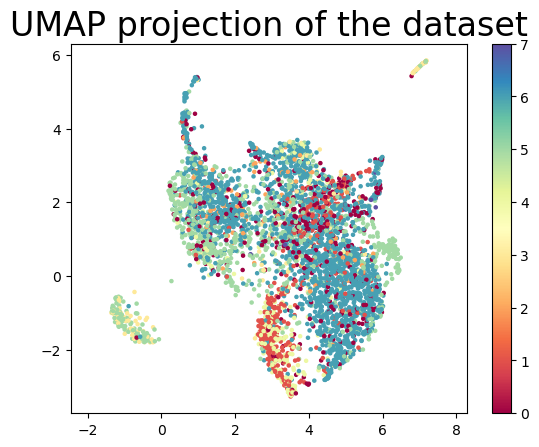

In [66]:
# Plotting the UMAP
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=vocSelTable['CalltypeInt'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the dataset', fontsize=24)
plt.show()

In [ ]:
# Take the z-scored PCA data and run UMAP on it

MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)

# umapAllData = umapFit.transform(Z_PCA_Balanced_All)

In [17]:
# You can start here (after loading dependencies) or skip if you already have vocSelTable

#Read the pandas table
vocSelTable = pd.read_hdf(tableStore)

,Bird,Calltype,Spectro
0,WhiWhi6607F,"[""0""]","[63.42924852709484, 56.11395765211436, -91.783..."
1,BluGre1214F,"[""6""]","[-35.66054279508094, -35.138289317089246, -66...."
2,BluGre1214F,"[""5""]","[-160.1451523706803, 14.28091251470568, 69.763..."
3,WhiWhi6607F,"[""6""]","[-129.66537858448933, 49.69354168400685, -46.6..."
4,BroGre1354M,"[""5""]","[-22.655207126976396, -50.65861418327188, 64.7..."
...,...,...,...
4339,WhiWhi1541M,"[""5""]","[165.7301080510281, 98.12409144917115, 121.599..."
4340,WhiWhi6607F,"[""6""]","[-147.47434274242164, 4.0269460199855285, 35.2..."
4341,WhiWhi6607F,"[""6""]","[-189.7559765072306, 49.89283010212444, 2.4461..."
4342,BluGre1214F,"[""6""]","[-109.68063959399092, -55.913246107242685, -52..."


In [2]:
# import our previously saved data
base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
data_file = os.path.join(base_folder, '_appdata/save/', 'segments.csv')
df = pd.read_csv(data_file)
df.describe()
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'SourceName', 'SourceChannel',
       'StartIndex', 'StopIndex', 'Tags', 'cluster', 'Coords'],
      dtype='object')

In [3]:
# You can also start the script here and skip the reading of h5 files and creation of table
# Read the vocSelTable
vocSelTable = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # haven't tried this yet
print(f"loading file: {os.path.join(base_folder, 'vocSelTableAmp.h5')} with {len(vocSelTable)} syllables")

loading file: /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/vocSelTableAmp.h5 with 4344 syllables
